In [58]:
from ultralytics import YOLO
import cv2
import supervision as sv
import numpy as np
import torch
from segment_anything import SamAutomaticMaskGenerator, SamPredictor, sam_model_registry
#import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [186]:
model = YOLO('/home/nikita/Desktop/diploma/Diploma/models/yolov8n-face.pt')  # load a pretrained YOLOv8n detection model
#model.train(data='coco128.yaml', epochs=3)  # train the model
#model('https://ultralytics.com/images/bus.jpg')  # predict on an image

In [187]:
sam = sam_model_registry["vit_l"](checkpoint="/home/nikita/Desktop/diploma/Diploma/models/sam_vit_l_0b3195.pth").to(device=device)
#predictor = SamPredictor(sam)
mask_generator = SamAutomaticMaskGenerator(sam)
mask_annotator = sv.MaskAnnotator()

In [185]:
image = Image.open('/home/nikita/Desktop/diploma/inference/sample/sample.png')

In [188]:
model.task='detect'
results = model.predict(image, imgsz=image.size,
                        save=False,
                        device=device,
                        hide_conf=True, hide_labels=True, conf=0.15, line_width=1)

WARNING ⚠️ 'hide_conf' is deprecated and will be removed in 'ultralytics 8.2' in the future. Please use 'show_conf' instead.
WARNING ⚠️ 'hide_labels' is deprecated and will be removed in 'ultralytics 8.2' in the future. Please use 'show_labels' instead.

0: 1280x1280 2 faces, 10.2ms
Speed: 5.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)


In [189]:
arr_of_boxes=[]
boxes = results[0].boxes
n=boxes.shape[0]


for i in range(n):
    arr=boxes.xyxy[i].cpu().numpy()
    arr[:2] *= 0.9
    arr[-2:] *= 1.1
    arr_of_boxes.append(arr)

In [190]:
arr_of_box_images=[]
for i in range(n):
    cropped_image = cv2.cvtColor(np.array(image.crop(arr_of_boxes[i])), cv2.COLOR_BGR2RGB)
    arr_of_box_images.append(cropped_image)
    # cropped_image.save(f'/home/nikita/Desktop/diploma/inference/sample/sample_{i}.png')

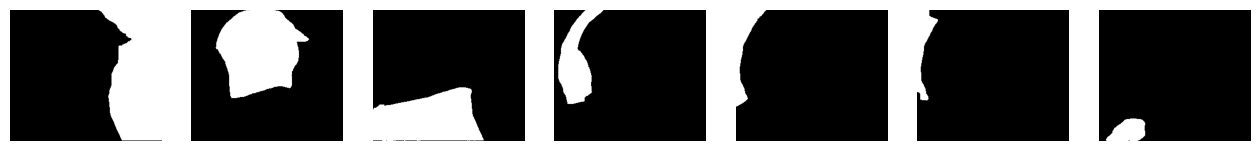

Выберите часть изображения, которую хотите исправить:


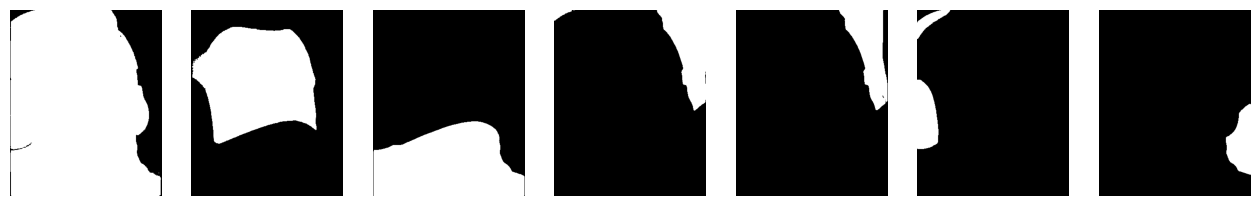

Выберите часть изображения, которую хотите исправить:


In [195]:
for i in range(n):
    image_bgr = arr_of_box_images[i]
    sam_result = mask_generator.generate(image_bgr)
    #detections = sv.Detections.from_sam(sam_result=sam_result)
    #annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)
    masks = [mask['segmentation'] for mask in sorted(sam_result, key=lambda x: x['area'], reverse=True)]
    sv.plot_images_grid(
    images=masks[:7],
    grid_size=(1, 7),
    size=(16, 16)
    )
    print('Выберите часть изображения, которую хотите исправить:')
    j=int(input())
    _, binary_mask = cv2.threshold(np.uint8(masks[j-1])*255, 127, 255, cv2.THRESH_BINARY)

    cv2.imwrite(f'/home/nikita/Desktop/diploma/inference/image/sample_{i}.png', image_bgr)
    cv2.imwrite(f'/home/nikita/Desktop/diploma/inference/mask/sample_{i}.png', binary_mask)
    

In [142]:
image_bgr = arr_of_box_images[0]

In [143]:
sam_result = mask_generator.generate(image_bgr)

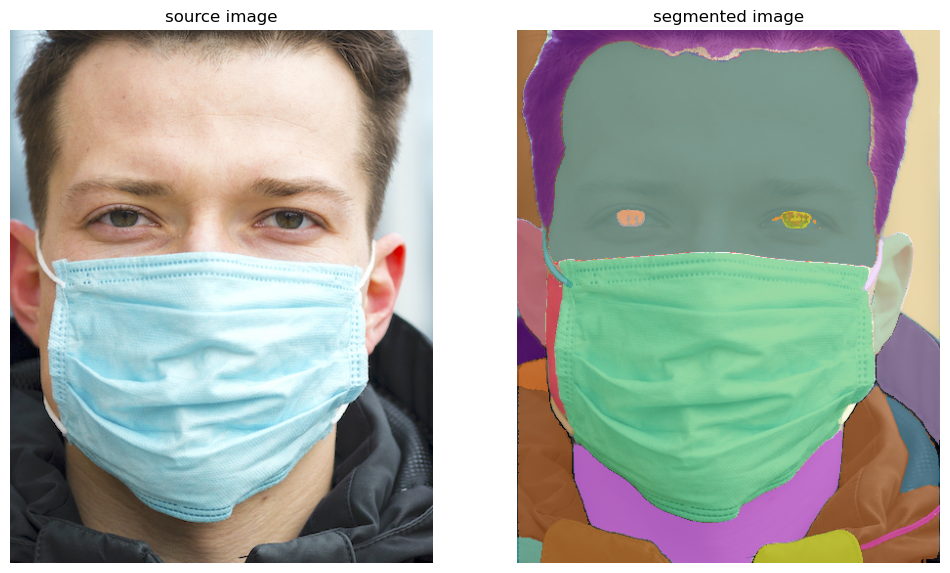

In [144]:
detections = sv.Detections.from_sam(sam_result=sam_result)
annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [145]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

len(masks)

30

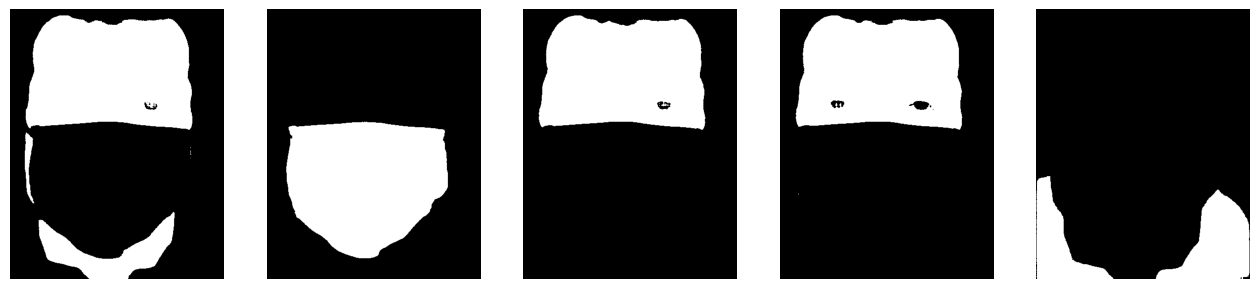

In [146]:
sv.plot_images_grid(
    images=masks[:5],
    grid_size=(1, 5),
    size=(16, 16)
)

In [192]:
_, binary = cv2.threshold(np.uint8(masks[1]) * 255, 127, 255, cv2.THRESH_BINARY)